# Caso de Negocio

### Puntaje de Valor del Cliente



En un entorno competitivo, las empresas buscan no solo adquirir nuevos clientes, sino también retener a los existentes y maximizar el valor que cada cliente aporta a lo largo de su vida. La personalización y la segmentación de clientes se han vuelto esenciales para aumentar la efectividad de las campañas de marketing.

Oportunidad: La mayoría de las empresas tienen datos valiosos sobre sus clientes, pero no siempre los utilizan de manera efectiva para clasificar y predecir el comportamiento futuro. Implementar un sistema de puntaje puede ayudar a las empresas a identificar a los clientes más valiosos y aquellos que necesitan atención.

# Selección de Variables

## Variable Objetivo:

La variable objetivo será el Puntaje Total del Cliente, que se calcula en función de múltiples métricas relacionadas con el comportamiento de compra y la lealtad del cliente.

Las métricas que se utilizarán para calcular el puntaje incluyen:

- **Frecuencia de Compra:** Número de transacciones realizadas por el cliente.
- **Gasto Total:** Total gastado por el cliente en un período determinado.
- **Antigüedad del Cliente:** Tiempo que el cliente ha estado activo (en días).

## Variables Independientes

### ayuda

# Selección de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.calibration import LabelEncoder

In [ ]:
df = pd.read_csv('/Transacciones_de_ventas Practicas.csv', encoding='latin-1')

df['Fecha'] = pd.to_datetime(df['Fecha'])

<ipython-input-18-3879985a36f1>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Fecha'] = pd.to_datetime(df['Fecha'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_1 = df.groupby(['Clave_Cliente','Transaccion']).agg({
    'Importe': 'sum',  # Valor total gastado por cliente hasta la fecha
    'Cantidad':'sum'
}).reset_index().groupby('Clave_Cliente').agg({
        'Transaccion':'count',
        'Importe': 'sum',
        'Cantidad': 'sum'
    }).reset_index().assign(importe_promedio = lambda x: x['Importe']/x['Transaccion'],
                            cantidad_promedio = lambda x: x['Cantidad']/x['Transaccion'])

df_2 = df.groupby('Clave_Cliente').agg(
    Fecha_Min=('Fecha', 'min'),
    Fecha_Max=('Fecha', 'max')
).reset_index().assign(dias = lambda x:  (x['Fecha_Max']-x['Fecha_Min']).dt.days+1)

df_merged = df_1.merge(df_2,how='inner',on='Clave_Cliente')
print(df_merged.head())

   Clave_Cliente  Transaccion   Importe  Cantidad  importe_promedio  \
0         100167           45   6791.96       250        150.932444   
1         100263           40   6951.88       250        173.797000   
2         100363            2    373.50        14        186.750000   
3         100491            2    328.00         8        164.000000   
4         100861           49  12792.41       414        261.069592   

   cantidad_promedio  Fecha_Min  Fecha_Max  dias  
0           5.555556 2014-01-28 2016-11-23  1031  
1           6.250000 2014-01-05 2016-11-10  1041  
2           7.000000 2016-02-12 2016-09-12   214  
3           4.000000 2016-01-12 2016-09-12   245  
4           8.448980 2014-01-22 2016-06-13   874  


In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0,100))

scaled_values = minmaxscaler.fit_transform(df_merged[['Transaccion','Importe','dias']].values)
scaled_df = pd.DataFrame(scaled_values, columns=['transaccion','importe','dias'])
scaled_df = scaled_df.assign(puntaje = lambda x: x['transaccion']*0.30 + x['importe']*0.60+x['dias']*0.10)
print(scaled_df)

     transaccion   importe       dias    puntaje
0      21.359223  4.189297  94.063927  18.327738
1      18.932039  4.288462  94.977169  17.750406
2       0.485437  0.209280  19.452055   2.216405
3       0.485437  0.181066  22.283105   2.482581
4      23.300971  7.910111  79.726027  19.708960
..           ...       ...        ...        ...
519     0.000000  0.070690   0.000000   0.042414
520     0.000000  0.126498   0.000000   0.075899
521     0.485437  0.389416   0.000000   0.379281
522     0.970874  0.216721  14.794521   1.900747
523     0.000000  0.622569   0.000000   0.373542

[524 rows x 4 columns]


In [26]:
df_premodel = df[['Clave_Cliente','No._Hijos','Antiguedad','Edad','Estado_Civil','Estado','Sexo','Grupo']].drop_duplicates()

df_premodel = df_premodel.merge(df_merged, on='Clave_Cliente',how='inner')
print(df_premodel.head())

   Clave_Cliente  No._Hijos  Antiguedad  Edad Estado_Civil      Estado  \
0         149580          0          11    35      Soltero  Nuevo Leon   
1         100861          0          15    41      Soltero  Nuevo Leon   
2         198695          0           3    34      Soltero  Nuevo Leon   
3         192182          0          38    63       Casado  Nuevo Leon   
4         112138          0          13    39      Soltero  Nuevo Leon   

        Sexo       Grupo  Transaccion   Importe  Cantidad  importe_promedio  \
0  Masculino  EJECUTIVOS            4   1902.00        53        475.500000   
1   Femenino   EMPLEADOS           49  12792.41       414        261.069592   
2   Femenino   EMPLEADOS           16   3603.40       116        225.212500   
3  Masculino  EJECUTIVOS           25  11347.92       300        453.916800   
4   Femenino   EMPLEADOS           54  23478.22      1001        434.781852   

   cantidad_promedio  Fecha_Min  Fecha_Max  dias  
0          13.250000 2014-01-

In [30]:
df_premodel = df_premodel[['No._Hijos','Antiguedad','Edad','Estado_Civil','Estado','Sexo','Grupo','importe_promedio','cantidad_promedio']]

df_premodel['puntaje'] = scaled_df['puntaje'].values
print(df_premodel.head())

   No._Hijos  Antiguedad  Edad Estado_Civil      Estado       Sexo  \
0          0          11    35      Soltero  Nuevo Leon  Masculino   
1          0          15    41      Soltero  Nuevo Leon   Femenino   
2          0           3    34      Soltero  Nuevo Leon   Femenino   
3          0          38    63       Casado  Nuevo Leon  Masculino   
4          0          13    39      Soltero  Nuevo Leon   Femenino   

        Grupo  importe_promedio  cantidad_promedio    puntaje  
0  EJECUTIVOS        475.500000          13.250000  18.327738  
1   EMPLEADOS        261.069592           8.448980  17.750406  
2   EMPLEADOS        225.212500           7.250000   2.216405  
3  EJECUTIVOS        453.916800          12.000000   2.482581  
4   EMPLEADOS        434.781852          18.537037  19.708960  


In [31]:
lbl_encoder = LabelEncoder()

df_model = df_premodel.copy().reset_index(drop=True)
df_model['Estado_Civil'] = lbl_encoder.fit_transform(df_model['Estado_Civil'])
df_model['Estado'] = lbl_encoder.fit_transform(df_model['Estado'])
df_model['Sexo'] = lbl_encoder.fit_transform(df_model['Sexo'])
df_model['Grupo'] = lbl_encoder.fit_transform(df_model['Grupo'])
print(df_model.head())

   No._Hijos  Antiguedad  Edad  Estado_Civil  Estado  Sexo  Grupo  \
0          0          11    35             4       9     1      1   
1          0          15    41             4       9     0      2   
2          0           3    34             4       9     0      2   
3          0          38    63             0       9     1      1   
4          0          13    39             4       9     0      2   

   importe_promedio  cantidad_promedio    puntaje  
0        475.500000          13.250000  18.327738  
1        261.069592           8.448980  17.750406  
2        225.212500           7.250000   2.216405  
3        453.916800          12.000000   2.482581  
4        434.781852          18.537037  19.708960  


# EDA

AYUDA (gráficas representativas para cada cada una de las características, ya que cuando el profe prguntó si por ejemplo variable x tiene más impacto en el modelo, a qué valores exactamente tiene esa variable x, la rpta estaba en las gráficas de tendencia de cada variable (al menos de las más representativas, ver + adelante))

# Modelos de Regresión

In [32]:
x_train, x_test, y_train, y_test =  train_test_split(df_model.drop(columns='puntaje'),df_model['puntaje'],test_size=0.3)

In [33]:
list_metrics = []
def save_metrics(model, y_test,predictions):
    rmse = root_mean_squared_error(y_test,predictions)
    r2 = r2_score(y_test,predictions)

    list_metrics.append([model.__class__.__name__,rmse,r2])

## Modelo 1:

In [60]:
regressor_1 = DecisionTreeRegressor(criterion='friedman_mse')

regressor_1.fit(x_train, y_train)
predictions_1 = regressor_1.predict(x_test)

importances = regressor_1.feature_importances_
indices_mas_importantes = np.argsort(importances)[-3:]
print(importances)

save_metrics(regressor_1, y_test, predictions_1)

[0.02103435 0.12280241 0.11242837 0.01737051 0.04203643 0.02450463
 0.00235955 0.21452359 0.44294018]


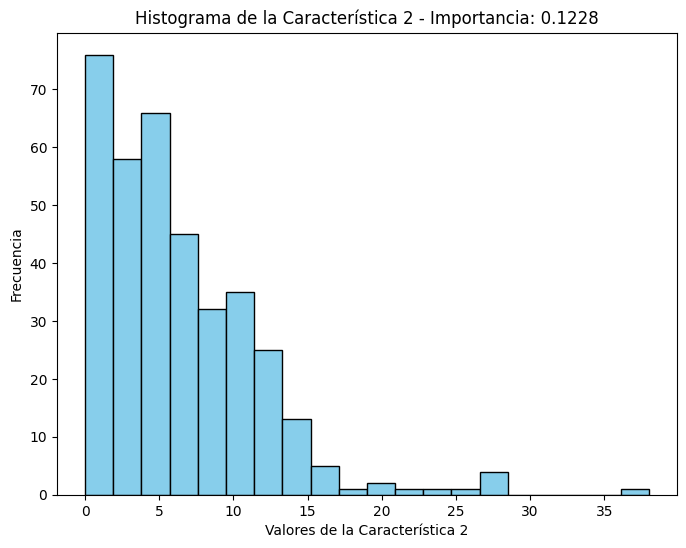

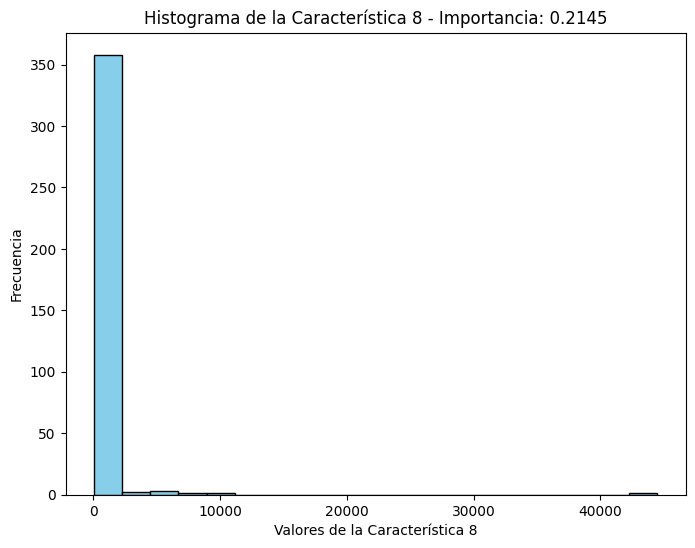

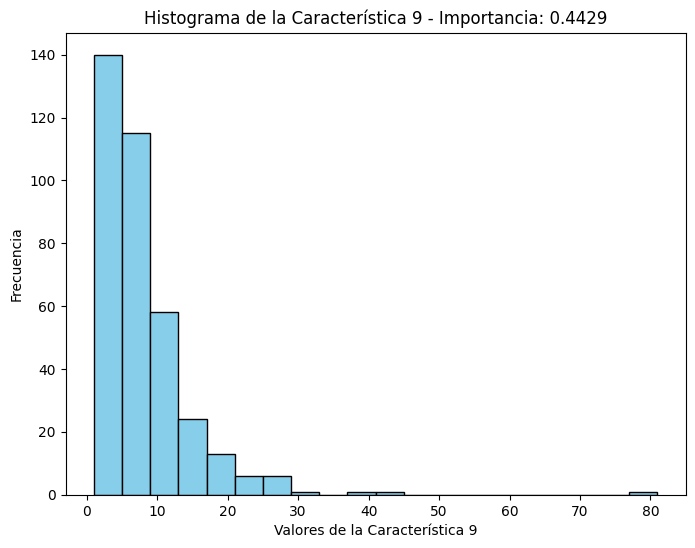

In [65]:
for i in indices_mas_importantes:
    plt.figure(figsize=(8, 6))

    # Asegurarse de acceder a la columna correcta en el DataFrame
    plt.hist(x_train.iloc[:, i], bins=20, color='skyblue', edgecolor='black')

    plt.title(f"Histograma de la Característica {i+1} - Importancia: {importances[i]:.4f}")
    plt.xlabel(f"Valores de la Característica {i+1}")
    plt.ylabel("Frecuencia")
    plt.show()

In [40]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.2 MB/s eta 0:00:00


# Grafíca SHAP
Muestra el comportamiento de los valores y la importancia de las variables en el modelo de regresión aplicado, mientras más a la derecha este el valor, más peso tendra en la predicción, todo lo contrario si está a la izquierda que la disminuye. Si el valor es roja es un valor alto si es azul es un valor bajo. (No se sabe que tan alto o bajos son los valores)

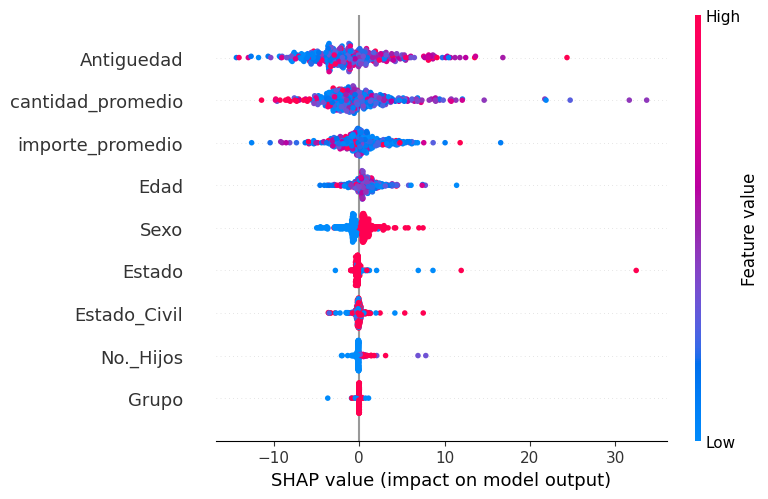

In [51]:
import shap

explainer = shap.Explainer(regressor_1)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, x_train)

### Impacto de Variables en el Modelo 1

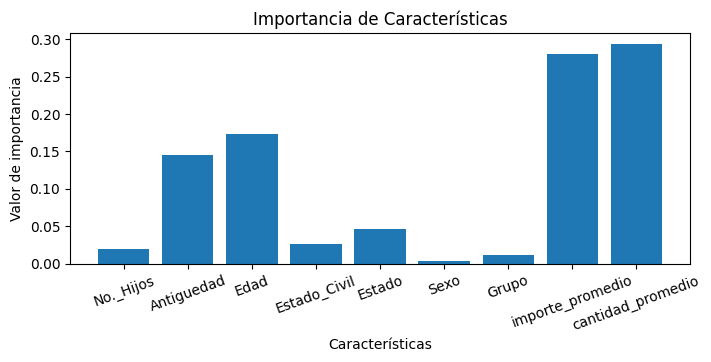

In [ ]:
plt.figure(figsize=(8, 3))
plt.bar(regressor_1.feature_names_in_, regressor_1.feature_importances_)
plt.title('Importancia de Características')
plt.xlabel('Características')
plt.ylabel('Valor de importancia')
plt.xticks(rotation=20)
plt.show()

### Evaluación de Modelo 1:

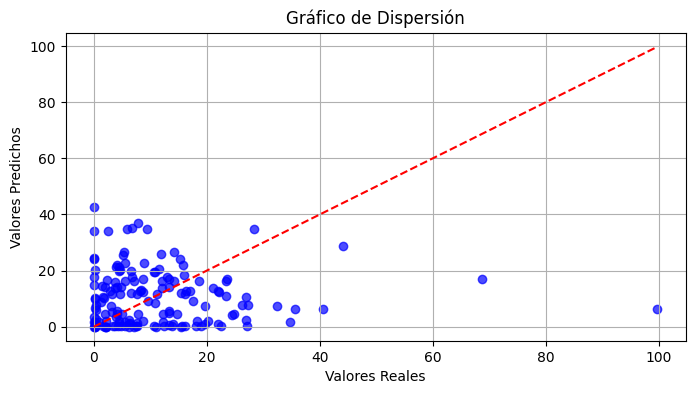

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(y_test, predictions_1, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
plt.title('Gráfico de Dispersión')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()


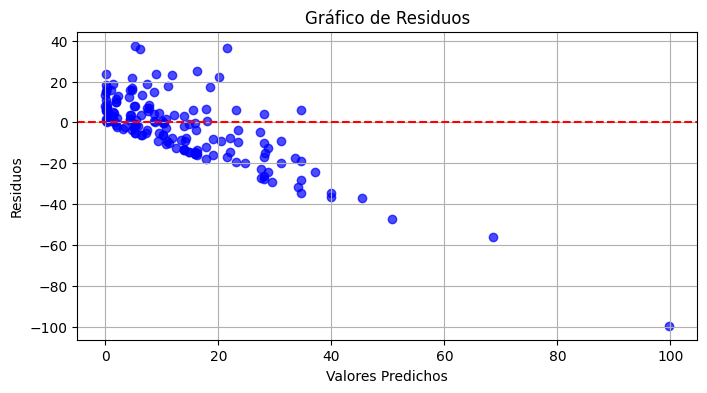

In [ ]:
# Calcular los residuos
residuos = [real - pred for real, pred in zip(y_test, predictions_1)]

plt.figure(figsize=(8, 4))
plt.scatter(predictions_1, residuos, color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Línea en y=0
plt.title('Gráfico de Residuos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()


## Modelo 2:

In [66]:
from sklearn.ensemble import GradientBoostingRegressor

regressor_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
regressor_2.fit(x_train, y_train)
predictions_2 = regressor_2.predict(x_test)

importances2 = regressor_2.feature_importances_
print(importances2)
indices_mas_importantes2 = np.argsort(importances2)[-3:]

save_metrics(regressor_2, y_test, predictions_2)

[0.02495738 0.15056308 0.10162603 0.01695419 0.0512218  0.00826725
 0.00613533 0.27572252 0.36455243]


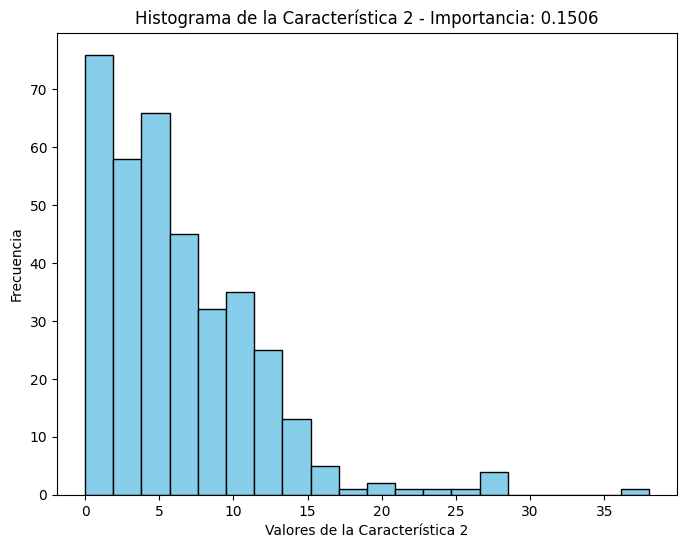

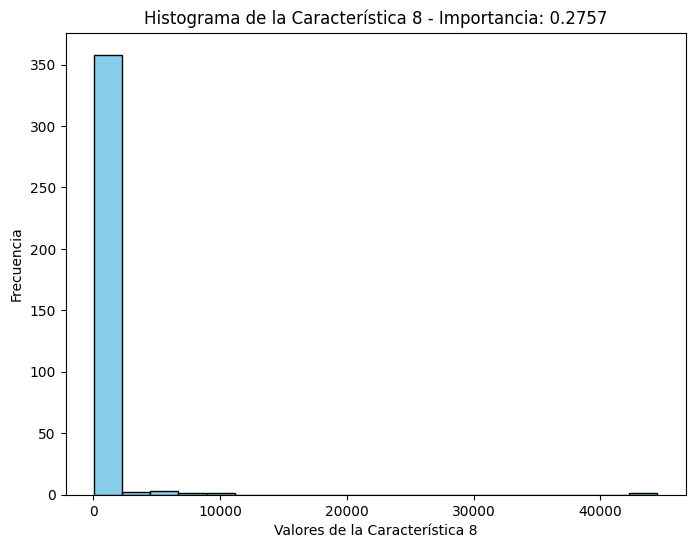

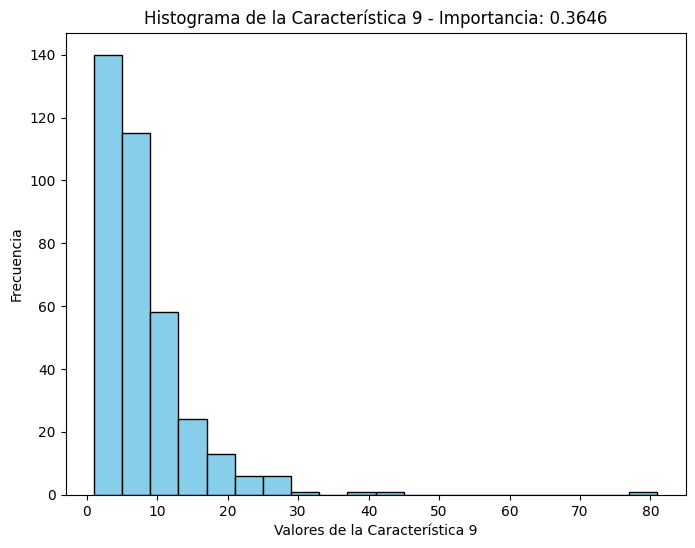

In [67]:
for i in indices_mas_importantes2:
    plt.figure(figsize=(8, 6))

    # Asegurarse de acceder a la columna correcta en el DataFrame
    plt.hist(x_train.iloc[:, i], bins=20, color='skyblue', edgecolor='black')

    plt.title(f"Histograma de la Característica {i+1} - Importancia: {importances2[i]:.4f}")
    plt.xlabel(f"Valores de la Característica {i+1}")
    plt.ylabel("Frecuencia")
    plt.show()

### Impacto de Variables en el Modelo 2

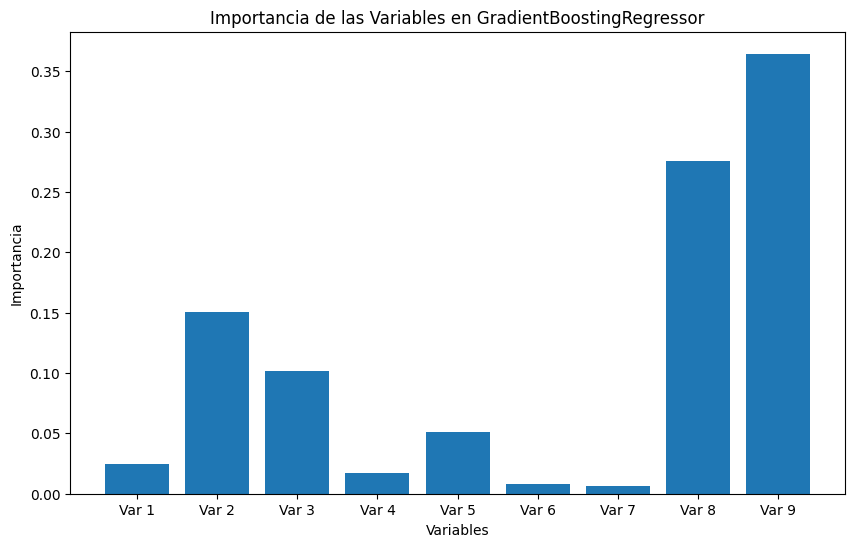

In [56]:
# Crear un gráfico de barras para visualizar las importancias
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(importances2)), importances2, align='center')
plt.xticks(np.arange(len(importances2)), [f"Var {i+1}" for i in range(len(importances2))])
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Importancia de las Variables en GradientBoostingRegressor')
plt.show()

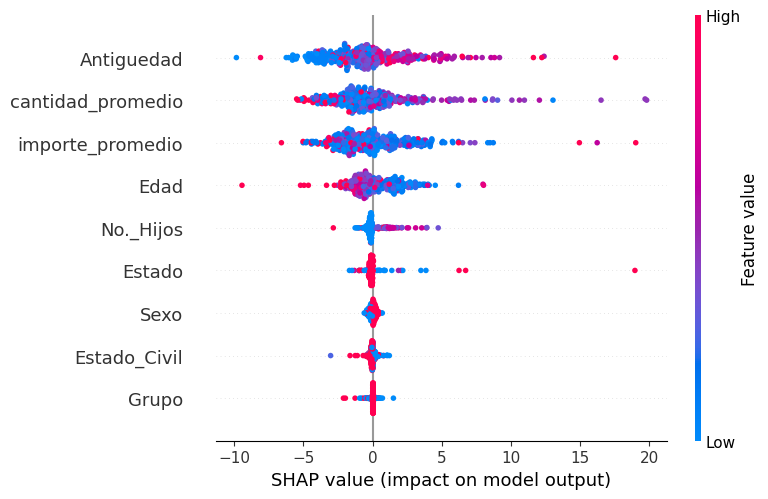

In [57]:
# Crear el explainer para Gradient Boosting
explainer2 = shap.Explainer(regressor_2)

# Obtener los valores SHAP para el conjunto de entrenamiento
shap_values = explainer2(x_train)

# Gráfico resumen de SHAP
shap.summary_plot(shap_values, x_train)

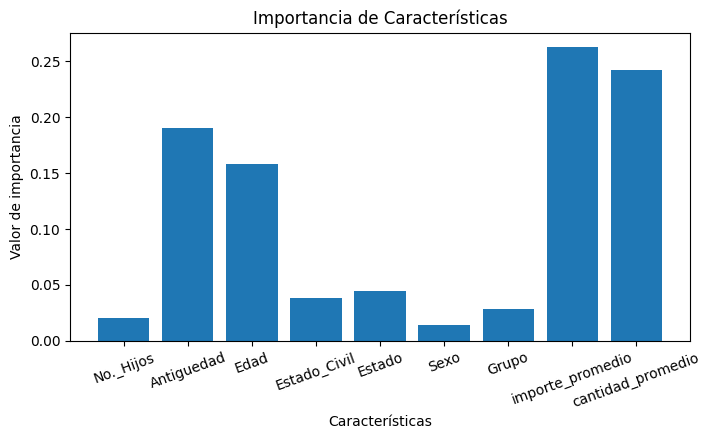

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(regressor_2.feature_names_in_, regressor_2.feature_importances_)
plt.title('Importancia de Características')
plt.xlabel('Características')
plt.ylabel('Valor de importancia')
plt.xticks(rotation=20)
plt.show()

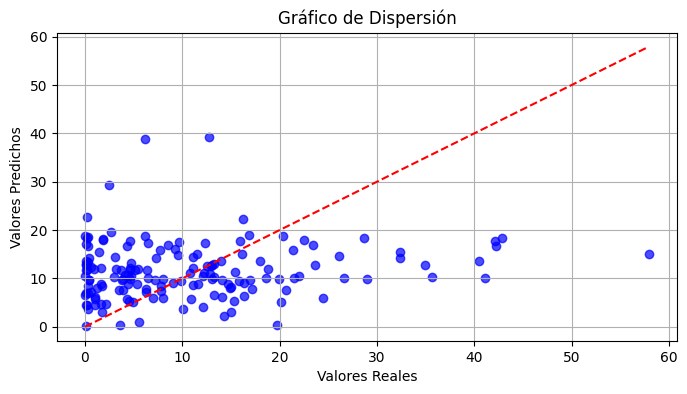

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(y_test, predictions_2, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
plt.title('Gráfico de Dispersión')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()


### Evaluación de Modelo 2

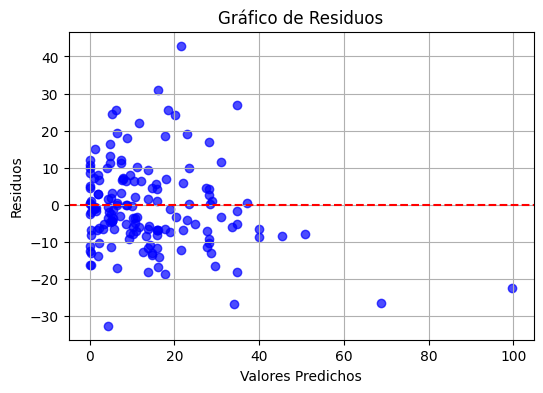

In [ ]:
# Calcular los residuos
residuos = [real - pred for real, pred in zip(y_test, predictions_2)]

plt.figure(figsize=(6, 4))
plt.scatter(predictions_1, residuos, color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Línea en y=0
plt.title('Gráfico de Residuos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()


# Conclusiones

Vemos que `GradientBoostingRegressor` nos da mejores resultados comparados a `DecisionTreeRegressor`, no usamos modelos de regresión lineal, polinómica, ridge, lasso, debido a que la naturaleza de los datos como se ven en las `gráficas de dispersión`, no se ajustan a una recta ya sea lineal o polinómica, vemos que nuestro score de clientes va de 0-100 pero obtenemos un `rmse` de 11.48, lo cual indica que tenemos un 10% de variación, lo cual es un buen indicador de nuestro modelo.  

Se hizo uso de SHAP para poder hallar la densidad de valores que tenian una fuerte influencia en los modelos, obteniendo que en ambos casos el `importe_promedio` y la `cantida_promedio` son las variables que más afectaron a nuestros modelos y el SHAP indica que los valores prediominantes eran bajos, más no nos inidica el o los valores como tal, solo que son bajos (azules)

In [ ]:
pd.DataFrame(list_metrics,columns=['model_name','root_mean_square_error','r2'])

,model_name,root_mean_square_error,r2
0,DecisionTreeRegressor,17.430798,-1.669506
1,GradientBoostingRegressor,11.484618,-0.158856
